# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-E,no-book-author,6551,9510
1,BX-E,ambiguous,4209,31204
2,BX-E,unknown,17002,27575
3,BX-E,no-author-rec,6875,8759
4,BX-E,female,38086,138860


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,217898.0,491598.0,17825.0,239641.0,141263.0,220528.0,936344.0,2265097.0
BX-E,38086.0,56450.0,4209.0,17002.0,6875.0,6551.0,21884.0,151057.0
BX-I,67147.0,98049.0,7141.0,34786.0,14006.0,13051.0,44070.0,278250.0
GR-E,175748.0,279496.0,11652.0,96509.0,30132.0,894244.0,NaN,1487781.0
GR-I,177359.0,282887.0,11759.0,98279.0,30847.0,908248.0,NaN,1509379.0
LOC-MDS,666637.0,2212575.0,54204.0,1219147.0,272591.0,842812.0,NaN,5267966.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,4352188.0,6623258.0,564273.0,2096617.0,737701.0,3573934.0,4510123.0
BX-E,138860.0,185728.0,31204.0,27575.0,8759.0,9510.0,25502.0
BX-I,391560.0,469582.0,78247.0,78092.0,23305.0,25923.0,62488.0
GR-E,34919275.0,35154413.0,8897037.0,3978567.0,531144.0,16921021.0,NaN
GR-I,76649781.0,71740687.0,14441256.0,10520265.0,1499802.0,46643099.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.096198,0.217032,0.007869,0.105797,0.062365,0.097359,0.413379
BX-E,0.252130,0.373700,0.027864,0.112554,0.045513,0.043368,0.144872
BX-I,0.241319,0.352377,0.025664,0.125017,0.050336,0.046904,0.158383
GR-E,0.118128,0.187861,0.007832,0.064868,0.020253,0.601059,NaN
GR-I,0.117505,0.187419,0.007791,0.065112,0.020437,0.601736,NaN
LOC-MDS,0.126545,0.420006,0.010289,0.231427,0.051745,0.159988,NaN


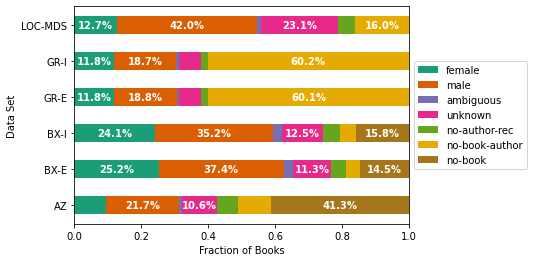

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.096198,0.217032,0.007869,0.105797,0.573103
BX-E,0.252130,0.373700,0.027864,0.112554,0.233753
BX-I,0.241319,0.352377,0.025664,0.125017,0.255623
GR-E,0.118128,0.187861,0.007832,0.064868,0.621312
GR-I,0.117505,0.187419,0.007791,0.065112,0.622173
LOC-MDS,0.126545,0.420006,0.010289,0.231427,0.211733


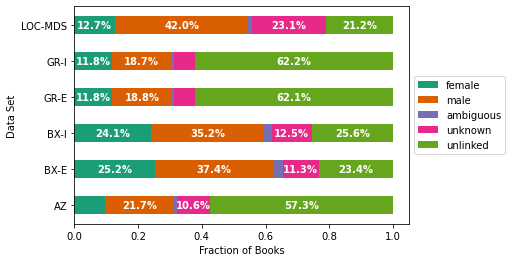

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

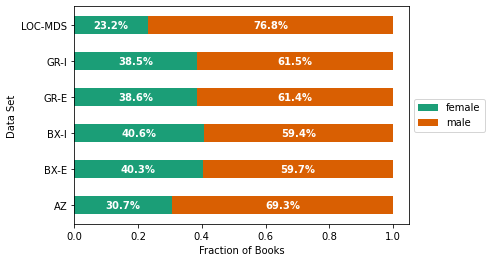

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.193792,0.294916,0.025126,0.093357,0.032848,0.159138,0.200824
BX-E,0.325094,0.434820,0.073054,0.064558,0.020506,0.022264,0.059704
BX-I,0.346760,0.415855,0.069294,0.069157,0.020639,0.022957,0.055338
GR-E,0.347796,0.350138,0.088615,0.039627,0.005290,0.168534,NaN
GR-I,0.346057,0.323893,0.065199,0.047497,0.006771,0.210583,NaN


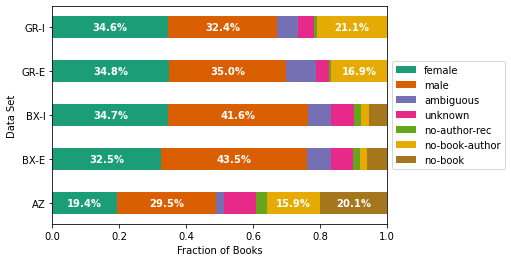

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.193792,0.294916,0.025126,0.093357,0.392810
BX-E,0.325094,0.434820,0.073054,0.064558,0.102475
BX-I,0.346760,0.415855,0.069294,0.069157,0.098934
GR-E,0.347796,0.350138,0.088615,0.039627,0.173824
GR-I,0.346057,0.323893,0.065199,0.047497,0.217354


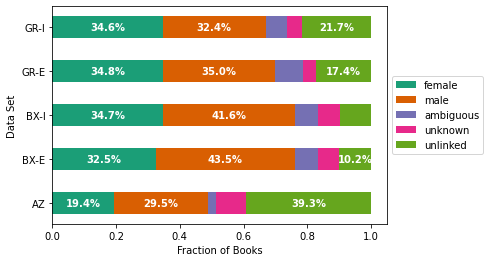

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

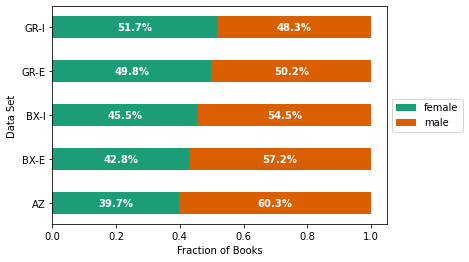

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ         0.321099
BX-E       0.653694
BX-I       0.619360
GR-E       0.313820
GR-I       0.312715
LOC-MDS    0.556840
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')